# Can we predict the category of an app from the app's description?

We wanted to see if we can create a Machine Learning model that will accuretly predict the category of an app from the app's description. To do this we created a web scraper to scrape data from the GooglePlay Store. After cleaning our data, we performed NLTK, Feature Engineering and Model Fitting to create an optimal ML Model. 

<br>

## Web Scraping

We created a web scraper to collect 60 app descriptions per category for 18 categories. After collecting our data we saved it to a file in dictionary format. 

In [1]:
import re
import pandas as pd
import numpy as np
read_dictionary = np.load('my_file.npy').item()

data  = read_dictionary

print(data.keys())
data['EDUCATION']

dict_keys(['EDUCATION', 'BUSINESS', 'DATING', 'SPORTS', 'WEATHER', 'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'BEAUTY', 'MUSIC_AND_AUDIO', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'SHOPPING', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'MEDICAL', 'PARENTING', 'COMMUNICATION', 'TOOLS'])


["⭐Es una App genial porque aprendes palabras nuevas y practicas la pronunciación a cada momento que desbloqueas tu pantalla.⭐Aprendes cada vez que abres tu teléfono. La forma más inconsciente de aprender eficazmente.¿Cuántas veces miras tu móvil al día?Lo miras un promedio de 100 veces al día y lo desbloqueas al menos 50 veces.¡Si estudiaras vocabulario en esos momentos en los que miras el móvil, podrías aprender unas 3,000 palabras en tan solo un mes!Wordbit inglés es una App que te permite estudiar inglés desde la pantalla de bloqueo de tu móvil.Excava valiosos tesoros desde tu pantalla bloqueada. Formará parte de tu rutina de aprendizaje.Además, ¡es totalmente gratis! ■ La memorización del vocabulario es la clave para el aprendizaje de cualquier lengua extranjeray la técnica más básica para memorizar el vocabulario es la repetición.Puedes memorizar el vocabulario mirándolo repetidamente y sin darte cuenta.¡Nuestra aplicación no sólo te ayudará a aprender nuevas palabras, sino tambi

<br>

## NLTK: Natural Language Tool Kit

In [2]:
import nltk
import sklearn

from nltk.collocations import *
from nltk import FreqDist, word_tokenize
import string, re
from nltk.stem.snowball import SnowballStemmer

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# stop words
from nltk.corpus import stopwords
stopwords.words("english")

stop_words = set(stopwords.words('english'))

# stem words
stemmer = SnowballStemmer("english")

In [3]:
def text_cleaner(description):
    '''uses regex to tokenize words and capture them from the description, 
    lowers the capitilization remove stop words, reduce to stem words, 
    and joins them all in a string'''
    tokens_raw = nltk.regexp_tokenize(description, pattern)
    tokens = [i.lower() for i in tokens_raw]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens_stopped]
    cleaned = ' '.join(stemmed)
    return cleaned



def dict_cleaner(dictionary):
    '''iterates through the dictionary values in each key (category) 
    and cleans each description and adds it back to a new list'''
    description_list = []
    for c, d in dictionary.items():
        for description in d:
            cleaned = text_cleaner(description)
            description_list.append(cleaned)
    return description_list


#use our function on our data
description_list = dict_cleaner(data)

#turn into df
new_df = pd.DataFrame(description_list, columns=['desc'])

In [4]:
new_df.head()

,desc
0,es una app genial porqu aprend palabra nueva p...
1,unlock math calcul math solut take photo math ...
2,learn anyth free forev spend afternoon brush s...
3,updat info latest updat new section ad learn l...
4,join million learner learn code make app game ...


<br>

## Test-Train-Split

In [5]:
#We have to create labels in order to label the words that appear in each category
def create_labels(dictionary):
    x = dictionary.keys()
    new_list = []
    for c in x: 
        s = [c] * len(dictionary[c])
        new_list += s
    return new_list


labels = create_labels(data)
new_df['labels'] = labels

print(new_df.shape)
new_df.columns

(1080, 2)


Index(['desc', 'labels'], dtype='object')

<br>

In [6]:
#we set our labels to y and set our features to x
y = new_df.labels

X = new_df.desc

#set our train and test data
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


<br>

## TF-IDF

We use Tf-Idif function to transform our data to reflect how important a word is in the collection of descriptions in each category.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)

# X_train = pd.DataFrame(train_df.toarray(), columns=tfidf.get_feature_names())

X_test = tfidf.transform(X_test)

In [8]:
X_test

<216x11665 sparse matrix of type '<class 'numpy.float64'>'
	with 22699 stored elements in Compressed Sparse Row format>

<br>

## Corpus Statistics

How many non-zero elements are there?

In [9]:
non_zero_cols = X_train.nnz / float(X_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Reviews: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(X_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Reviews: 112.73032407407408
Percentage of columns containing 0: 0.9903360202251115


<br>

## K-Nearest Neighbor

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)

knn_train_score = accuracy_score(y_train, knn_train_preds)
knn_test_score = accuracy_score(y_test, knn_test_preds)

print("KNN")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(knn_train_score, knn_test_score))
print("F1 Score: {}".format(f1_score(y_test, knn_test_preds, average='micro')))

KNN
Training Accuracy: 0.831 		 Testing Accuracy: 0.7639
F1 Score: 0.763888888888889


<br>

## Naive-Bayes Multinomial Classifier

In [106]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("F1 Score: {}".format(f1_score(y_test, nb_test_preds, average='micro')))

Multinomial Naive Bayes
Training Accuracy: 0.9213 		 Testing Accuracy: 0.7454
F1 Score: 0.7453703703703705


<br>

## Random Forest Classifier

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50)

rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
print("F1 Score: {}".format(f1_score(y_test, rf_test_preds, average='micro')))

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.7546
F1 Score: 0.7546296296296298


<br>

## SVM

In [109]:
from sklearn import svm

svm_clf = svm.SVC(probability=True)

svm_clf.fit(X_train, y_train)
svm_train_preds = rf_classifier.predict(X_train)
svm_test_preds = rf_classifier.predict(X_test)

svm_train_score = accuracy_score(y_train, svm_train_preds)
svm_test_score = accuracy_score(y_test, svm_test_preds)

print('SVM')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(svm_train_score, svm_test_score))
print("F1 Score: {}".format(f1_score(y_test, svm_test_preds, average='micro')))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM
Training Accuracy: 1.0 		 Testing Accuracy: 0.7546
F1 Score: 0.7546296296296298


<br>

## TPOT for automated model selection

In [ ]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=5, cv = 3 ,population_size=20,\
                      max_eval_time_mins=10, verbosity=3)


#we ran the classifier, which will tell us the best model to use.
tpot.fit(X_train, y_train)


'''After changing the generation and population parameters to get better results, 
   we came up with the final best result. 
   The Automated model selection gave us the best model to use which yielded: 
   
   
   exported_pipeline = LinearSVC(C=1, dual=True, loss="squared_hinge", penalty="l2")'''



<br>

## LinearSVC

In [26]:
from sklearn.svm import LinearSVC

lsvc_classifier = LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

lsvc_classifier.fit(X_train, y_train)
lsvc_train_preds = lsvc_classifier.predict(X_train)
lsvc_test_preds = lsvc_classifier.predict(X_test)

lsvc_train_score = accuracy_score(y_train, lsvc_train_preds)
lsvc_test_score = accuracy_score(y_test, lsvc_test_preds)

print('LinearSVC')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(lsvc_train_score, lsvc_test_score))
print("F1 Score: {}".format(f1_score(y_test, lsvc_test_preds, average='micro')))

LinearSVC
Training Accuracy: 1.0 		 Testing Accuracy: 0.8102
F1 Score: 0.8101851851851852


## Gradient Boosting

In [114]:
from sklearn.ensemble import GradientBoostingClassifier


gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

gb_clf.fit(X_train, y_train)
gb_train_preds = gb_clf.predict(X_train)
gb_test_preds = gb_clf.predict(X_test)

gb_train_score = accuracy_score(y_train, gb_train_preds)
gb_test_score = accuracy_score(y_test, gb_test_preds)

print('Gradient Boosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

Gradient Boosting
Training Accuracy: 0.9514 		 Testing Accuracy: 0.7222
F1 Score: 0.7222222222222222


<br>

## AdaBoosting

In [115]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()

adaboost_clf.fit(X_train, y_train)
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

print('AdaBoosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

AdaBoosting
Training Accuracy: 0.2326 		 Testing Accuracy: 0.1759
F1 Score: 0.17592592592592593


## XGBoosting

In [116]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

xgb_train_score = accuracy_score(y_train, xgb_train_preds)
xgb_test_score = accuracy_score(y_test, xgb_test_preds)

print('AdaBoosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(xgb_train_score, xgb_test_score))
print("F1 Score: {}".format(f1_score(y_test, xgb_test_preds, average='micro')))

AdaBoosting
Training Accuracy: 1.0 		 Testing Accuracy: 0.6759
F1 Score: 0.6759259259259259


## Voting Classifier

In [117]:
from sklearn.ensemble import VotingClassifier


svc1 = LinearSVC(C=25.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.001)
svc2 = LinearSVC(C=1.0, dual=True, loss="hinge", penalty="l2", tol=1e-05)



vc_clf = VotingClassifier(estimators=[('svc1', svc1), 
                                     ('svc2', svc2),
                                     ('gb_clf', gb_clf),
                                    ('nb', nb_classifier),
                                    ('knn', knn),
                                    ('rf', rf_classifier)], voting='hard')

vc_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc1', LinearSVC(C=25.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)), ('svc2', LinearSVC(C=1.0, class_weight=None, dual=True, fit_i...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [118]:
vc_train_preds = vc_clf.predict(X_train)
vc_test_preds = vc_clf.predict(X_test)

vc_train_score = accuracy_score(y_train, vc_train_preds)
vc_test_score = accuracy_score(y_test, vc_test_preds)

print('Voting Classifier')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(vc_train_score, vc_test_score))
print("F1 Score: {}".format(f1_score(y_test, vc_test_preds, average='micro')))

Voting Classifier
Training Accuracy: 0.9722 		 Testing Accuracy: 0.8148
F1 Score: 0.8148148148148148


## PCA Experiment

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(.95)
new_train = pca.fit_transform(X_train)

# pca_train = pca.fit_transform(X_train)
# pca_test = pca.transform(X_test)



<br>

## Visual Analysis

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, lsvc_test_preds)
cate = data.keys()

Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  1  0  0  0  0  1  0  2  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  8  0  0  0  2  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1 15  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  3  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  4  1  0  0  0  0  0  0  1  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 10  0  0]
 [ 1  1  1  0  0  0  1  0  0  0  1  0  2  0  0  

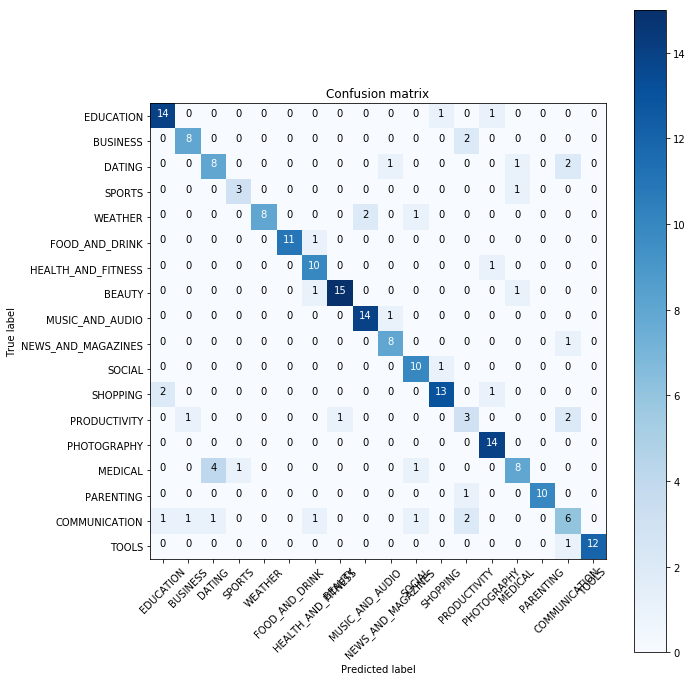

In [29]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, cate)

In [30]:
print(classification_report(y_test, lsvc_test_preds))

                    precision    recall  f1-score   support

            BEAUTY       0.82      0.88      0.85        16
          BUSINESS       0.80      0.80      0.80        10
     COMMUNICATION       0.62      0.67      0.64        12
            DATING       0.75      0.75      0.75         4
         EDUCATION       1.00      0.73      0.84        11
    FOOD_AND_DRINK       1.00      0.92      0.96        12
HEALTH_AND_FITNESS       0.77      0.91      0.83        11
           MEDICAL       0.94      0.88      0.91        17
   MUSIC_AND_AUDIO       0.88      0.93      0.90        15
NEWS_AND_MAGAZINES       0.80      0.89      0.84         9
         PARENTING       0.77      0.91      0.83        11
       PHOTOGRAPHY       0.87      0.81      0.84        16
      PRODUCTIVITY       0.38      0.43      0.40         7
          SHOPPING       0.82      1.00      0.90        14
            SOCIAL       0.73      0.57      0.64        14
            SPORTS       1.00      0.91